<a href="https://colab.research.google.com/github/ivn-srg/data-analysis-course-omsu/blob/main/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5%209/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_9_%D0%90%D0%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="background-color: #001f3f; color: #ff0; padding: 12px; border: 2px solid #fff; text-align: center;border-radius: 8px;">Ad Click Prediction</h1>


In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from scipy.stats import norm, skew, probplot
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings(action='ignore')

# EDA - Exploratory Data Analysis

In [73]:
data = pd.read_csv("/content/ad_click_dataset.csv")
data

id full_name   age      gender device_type ad_position  \
0      670   User670  22.0         NaN     Desktop         Top   
1     3044  User3044   NaN        Male     Desktop         Top   
2     5912  User5912  41.0  Non-Binary         NaN        Side   
3     5418  User5418  34.0        Male         NaN         NaN   
4     9452  User9452  39.0  Non-Binary         NaN         NaN   
...    ...       ...   ...         ...         ...         ...   
9995  8510  User8510   NaN         NaN      Mobile         Top   
9996  7843  User7843   NaN      Female     Desktop      Bottom   
9997  3914  User3914   NaN        Male      Mobile        Side   
9998  7924  User7924   NaN         NaN     Desktop         NaN   
9999  3056  User3056  44.0        Male      Tablet         Top   

     browsing_history time_of_day  click  
0            Shopping   Afternoon      1  
1                 NaN         NaN      1  
2           Education       Night      1  
3       Entertainment     Evening      1  
4        Social Media     Morning      0  
...               ...         ...    ...  
9995        Education         NaN      0  
9996    Entertainment         NaN      0  
9997              NaN     Morning      0  
9998         Shopping     Morning      1  
9999     Social Media     Morning      0  

[10000 rows x 9 columns]

In [74]:
data = data.drop(columns=['id','full_name'], axis=1)

In [75]:
data.shape

(10000, 7)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               5234 non-null   float64
 1   gender            5307 non-null   object 
 2   device_type       8000 non-null   object 
 3   ad_position       8000 non-null   object 
 4   browsing_history  5218 non-null   object 
 5   time_of_day       8000 non-null   object 
 6   click             10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


In [77]:
data

age      gender device_type ad_position browsing_history time_of_day  \
0     22.0         NaN     Desktop         Top         Shopping   Afternoon   
1      NaN        Male     Desktop         Top              NaN         NaN   
2     41.0  Non-Binary         NaN        Side        Education       Night   
3     34.0        Male         NaN         NaN    Entertainment     Evening   
4     39.0  Non-Binary         NaN         NaN     Social Media     Morning   
...    ...         ...         ...         ...              ...         ...   
9995   NaN         NaN      Mobile         Top        Education         NaN   
9996   NaN      Female     Desktop      Bottom    Entertainment         NaN   
9997   NaN        Male      Mobile        Side              NaN     Morning   
9998   NaN         NaN     Desktop         NaN         Shopping     Morning   
9999  44.0        Male      Tablet         Top     Social Media     Morning   

      click  
0         1  
1         1  
2         1  
3         1  
4         0  
...     ...  
9995      0  
9996      0  
9997      0  
9998      1  
9999      0  

[10000 rows x 7 columns]

In [78]:
num_cols = data.select_dtypes(include=['float64', 'int64'])
cat_cols = data.select_dtypes(include=['object'])

print('Numeric Variables:')
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['age', 'click']

Categorical Variables:
['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']


In [79]:
for col in cat_cols:
  print('We Have {} Unique values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
  print('__'*30)

We Have 4 Unique values. Values in the gender Column: [nan 'Male' 'Non-Binary' 'Female']
____________________________________________________________
We Have 4 Unique values. Values in the device_type Column: ['Desktop' nan 'Mobile' 'Tablet']
____________________________________________________________
We Have 4 Unique values. Values in the ad_position Column: ['Top' 'Side' nan 'Bottom']
____________________________________________________________
We Have 6 Unique values. Values in the browsing_history Column: ['Shopping' nan 'Education' 'Entertainment' 'Social Media' 'News']
____________________________________________________________
We Have 5 Unique values. Values in the time_of_day Column: ['Afternoon' nan 'Night' 'Evening' 'Morning']
____________________________________________________________


In [80]:
data.describe().T

count       mean        std   min   25%   50%   75%   max
age     5234.0  40.197363  13.126420  18.0  29.0  39.5  52.0  64.0
click  10000.0   0.650000   0.476993   0.0   0.0   1.0   1.0   1.0

In [81]:
for feature in num_cols:
  zero_values = (data[feature] == 0).sum()
  null_values = data[feature].isnull().sum()
  unique_values = len(data[feature].unique())

  print(f"Feature: {feature}")
  print(f"Number of 0 Values: {zero_values}")
  print(f"Number of Null Values: {null_values}")
  print(f"Unique Values: {unique_values}")
  print("="*30)

Feature: age
Number of 0 Values: 0
Number of Null Values: 4766
Unique Values: 48
Feature: click
Number of 0 Values: 3500
Number of Null Values: 0
Unique Values: 2


# Missing Values

In [82]:
data.isnull().sum()

age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

<Axes: title={'center': 'Heatmap for the null values in each column'}>

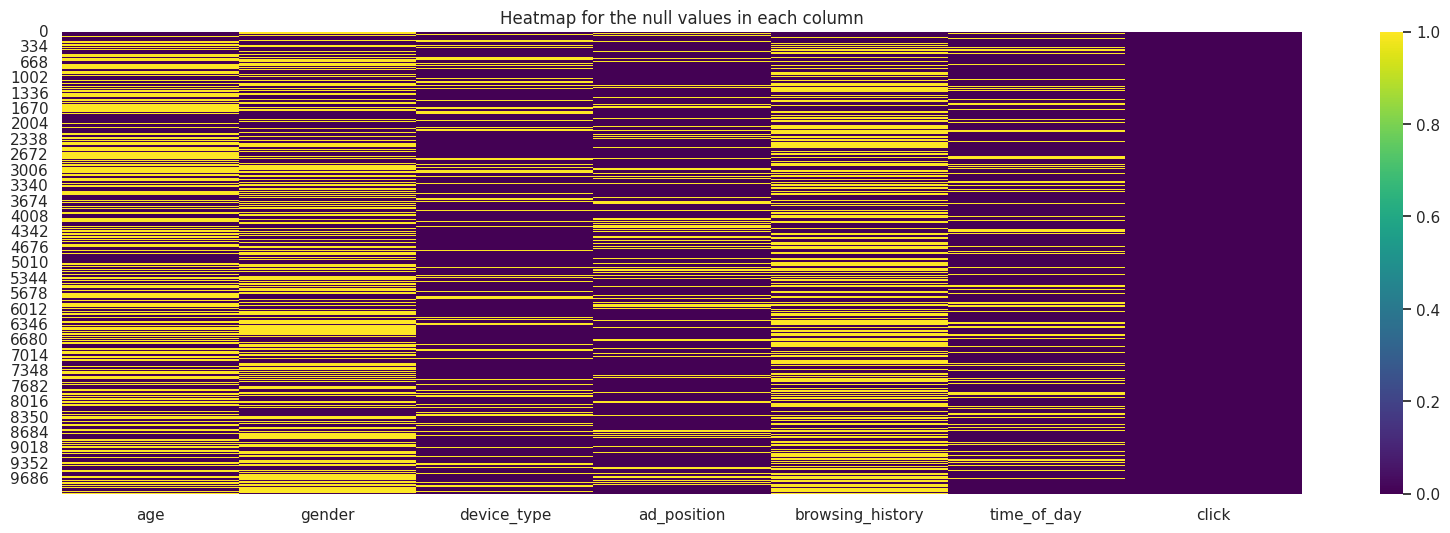

In [83]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for the null values in each column')
sns.heatmap(data.isnull(),cmap='viridis')

**–ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –º–µ—Ç–æ–¥–∞ KNN –¥–ª—è –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π. –°–Ω–∞—á–∞–ª–∞ –ø—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º —Å—Ç—Ä–æ–∫–∏ —Å –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏, —á—Ç–æ–±—ã –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –ø–æ–¥—Ö–æ–¥—è—â–∏—Ö —Å–æ—Å–µ–¥–µ–π.**

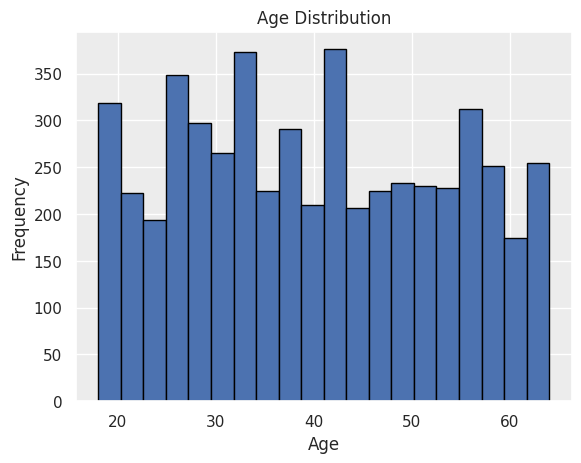

In [84]:
plt.hist(data['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

**üí° –ß—Ç–æ –¥–µ–ª–∞–µ—Ç KNNImputer:**

KNNImputer ‚Äî —ç—Ç–æ –º–µ—Ç–æ–¥ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏—è –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π, –∫–æ—Ç–æ—Ä—ã–π –∏—â–µ—Ç –ø–æ—Ö–æ–∂–∏–µ —Å—Ç—Ä–æ–∫–∏ (–ø–æ –¥—Ä—É–≥–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º) –∏ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –∏—Ö –∑–Ω–∞—á–µ–Ω–∏—è, —á—Ç–æ–±—ã –∑–∞–ø–æ–ª–Ω–∏—Ç—å –ø—É—Å—Ç–æ—Ç—ã.

**üîç –ö–∞–∫ —ç—Ç–æ —Ä–∞–±–æ—Ç–∞–µ—Ç –ø–æ—à–∞–≥–æ–≤–æ:**

- –î–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏ —Å –ø—Ä–æ–ø—É—Å–∫–æ–º –∞–ª–≥–æ—Ä–∏—Ç–º –Ω–∞—Ö–æ–¥–∏—Ç k –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π (–¥—Ä—É–≥–∏–µ —Å—Ç—Ä–æ–∫–∏ –±–µ–∑ –ø—Ä–æ–ø—É—Å–∫–∞ –≤ —ç—Ç–æ–º –º–µ—Å—Ç–µ), –∫–æ—Ç–æ—Ä—ã–µ –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ –ø–æ—Ö–æ–∂–∏ –ø–æ –æ—Å—Ç–∞–ª—å–Ω—ã–º –ø—Ä–∏–∑–Ω–∞–∫–∞–º.

- –°–º–æ—Ç—Ä–∏—Ç, —á—Ç–æ —É —ç—Ç–∏—Ö —Å–æ—Å–µ–¥–µ–π –≤ –Ω—É–∂–Ω–æ–π —è—á–µ–π–∫–µ:

 - –ï—Å–ª–∏ —ç—Ç–æ —á–∏—Å–ª–æ ‚Äî –±–µ—Ä–µ—Ç —Å—Ä–µ–¥–Ω–µ–µ.

 - –ï—Å–ª–∏ —ç—Ç–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è ‚Äî —Å–Ω–∞—á–∞–ª–∞ –∫–æ–¥–∏—Ä—É–µ—Ç –µ—ë –∫–∞–∫ —á–∏—Å–ª–æ, –ø–æ—Ç–æ–º –±–µ—Ä–µ—Ç —Å—Ä–µ–¥–Ω–µ–µ, –æ–∫—Ä—É–≥–ª—è–µ—Ç –¥–æ –±–ª–∏–∂–∞–π—à–µ–≥–æ —Ü–µ–ª–æ–≥–æ –∏ –¥–µ–∫–æ–¥–∏—Ä—É–µ—Ç –æ–±—Ä–∞—Ç–Ω–æ.

- –í—Å—Ç–∞–≤–ª—è–µ—Ç –Ω–∞–π–¥–µ–Ω–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –Ω–∞ –º–µ—Å—Ç–æ –ø—Ä–æ–ø—É—Å–∫–∞.

In [85]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def knn_impute_all(data, n_neighbors=5):
    # –°–æ–∑–¥–∞–µ–º –∫–æ–ø–∏—é –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
    df = data.copy()

    # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –∏ —á–∏—Å–ª–æ–≤—ã–µ —Å—Ç–æ–ª–±—Ü—ã
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    num_cols = df.select_dtypes(include=[np.number]).columns

    # –°–ª–æ–≤–∞—Ä—å –¥–ª—è –æ–±—Ä–∞—Ç–Ω–æ–≥–æ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –∫–∞—Ç–µ–≥–æ—Ä–∏–π
    category_mappings = {}

    # –ó–∞–∫–æ–¥–∏—Ä—É–µ–º –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ
    for col in cat_cols:
        df[col] = df[col].astype('category')
        category_mappings[col] = dict(enumerate(df[col].cat.categories))
        df[col] = df[col].cat.codes.replace(-1, np.nan)  # –ø—Ä–æ–ø—É—Å–∫–∏ –∫–∞–∫ np.nan

    # –ü—Ä–∏–º–µ–Ω—è–µ–º KNNImputer –∫–æ –≤—Å–µ–º—É –¥–∞—Ç–∞—Ñ—Ä–µ–π–º—É
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed_array = imputer.fit_transform(df)

    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç –≤ DataFrame
    df_imputed = pd.DataFrame(df_imputed_array, columns=df.columns)

    # –û–±—Ä–∞—Ç–Ω–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö
    for col in cat_cols:
        df_imputed[col] = df_imputed[col].round().astype(int).map(category_mappings[col])

    return df_imputed


# üîß –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è:
df_imputed = knn_impute_all(data)
data = df_imputed

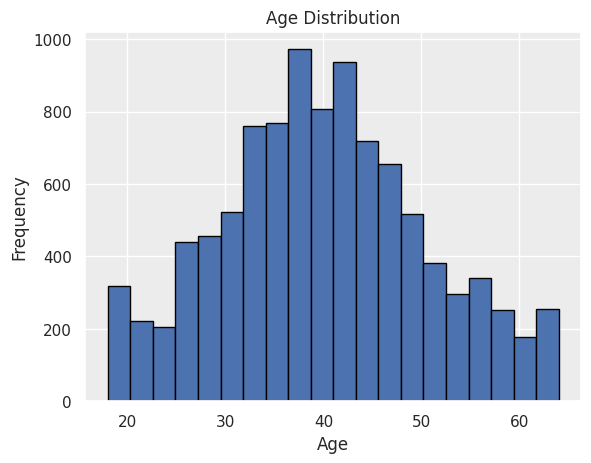

In [86]:
plt.hist(data['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [87]:
data.isnull().sum()

age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

–¢–µ—Å—Ç –°—Ç—å—é–¥–µ–Ω—Ç–∞ (–ø—Ä–æ–≤–µ—Ä–∫–∞ —Ä–∞–∑–ª–∏—á–∏–π –ø–æ –≤–æ–∑—Ä–∞—Å—Ç—É –º–µ–∂–¥—É –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏ –∏ –Ω–µ –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏)

| –¢–µ–º–∞              | –ß—Ç–æ –ø—Ä–æ–≤–µ—Ä—è–µ—Ç                          | –ö–æ–≥–¥–∞ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è                        |
|-------------------|----------------------------------------|-------------------------------------------|
| –¢–µ—Å—Ç –°—Ç—å—é–¥–µ–Ω—Ç–∞     | –°—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–∏–º–æ —Ä–∞–∑–ª–∏—á–∞—é—Ç—Å—è?           | –°—Ä–∞–≤–Ω–∏—Ç—å 2 –≥—Ä—É–ø–ø—ã                         |
| –¢–µ—Å—Ç –†–∞–º—Å–µ—è        | –°–ø–µ—Ü–∏—Ñ–∏–∫–∞—Ü–∏—è —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –≤–µ—Ä–Ω–∞?          | –ü—Ä–æ–≤–µ—Ä–∏—Ç—å –ø–æ–ª–Ω–æ—Ç—É –º–æ–¥–µ–ª–∏                  |



In [88]:
from scipy.stats import ttest_ind

# –†–∞–∑–¥–µ–ª—è–µ–º –¥–∞–Ω–Ω—ã–µ –Ω–∞ 2 –≥—Ä—É–ø–ø—ã: –∫–ª–∏–∫–Ω—É–ª–∏ –∏ –Ω–µ –∫–ª–∏–∫–Ω—É–ª–∏
clicked = data[data['click'] == 1]['age']
not_clicked = data[data['click'] == 0]['age']

# –ü—Ä–∏–º–µ–Ω—è–µ–º –Ω–µ–∑–∞–≤–∏—Å–∏–º—ã–π —Ç–µ—Å—Ç –°—Ç—å—é–¥–µ–Ω—Ç–∞
t_stat, p_value = ttest_ind(clicked, not_clicked)

print(f"–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ t-—Ç–µ—Å—Ç–∞: {t_stat:.4f}")
print(f"P-–∑–Ω–∞—á–µ–Ω–∏–µ: {p_value:.4f}")

# –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è:
if p_value < 0.05:
    print('–í—ã–≤–æ–¥: –µ—Å—Ç—å —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ–µ —Ä–∞–∑–ª–∏—á–∏–µ –≤ –≤–æ–∑—Ä–∞—Å—Ç–µ –º–µ–∂–¥—É –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏ –∏ –Ω–µ –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏.')
else:
    print('–í—ã–≤–æ–¥: –Ω–µ—Ç —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ–≥–æ —Ä–∞–∑–ª–∏—á–∏—è –≤ –≤–æ–∑—Ä–∞—Å—Ç–µ –º–µ–∂–¥—É –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏ –∏ –Ω–µ –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏.')


–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ t-—Ç–µ—Å—Ç–∞: -13.2334
P-–∑–Ω–∞—á–µ–Ω–∏–µ: 0.0000
–í—ã–≤–æ–¥: –µ—Å—Ç—å —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ–µ —Ä–∞–∑–ª–∏—á–∏–µ –≤ –≤–æ–∑—Ä–∞—Å—Ç–µ –º–µ–∂–¥—É –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏ –∏ –Ω–µ –∫–ª–∏–∫–Ω—É–≤—à–∏–º–∏.


# Correlation

In [89]:
corr = num_cols.corr()
corr

age     click
age    1.000000 -0.082056
click -0.082056  1.000000

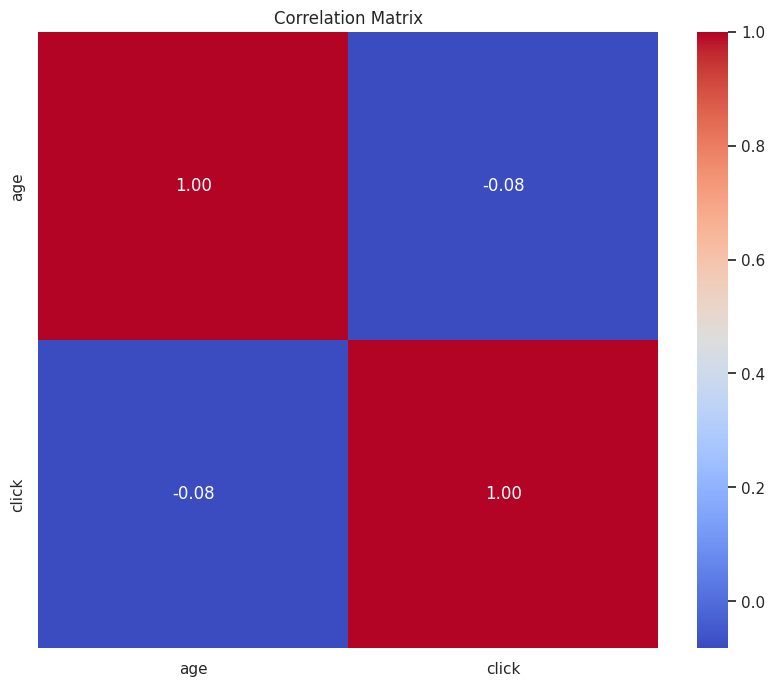

In [90]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

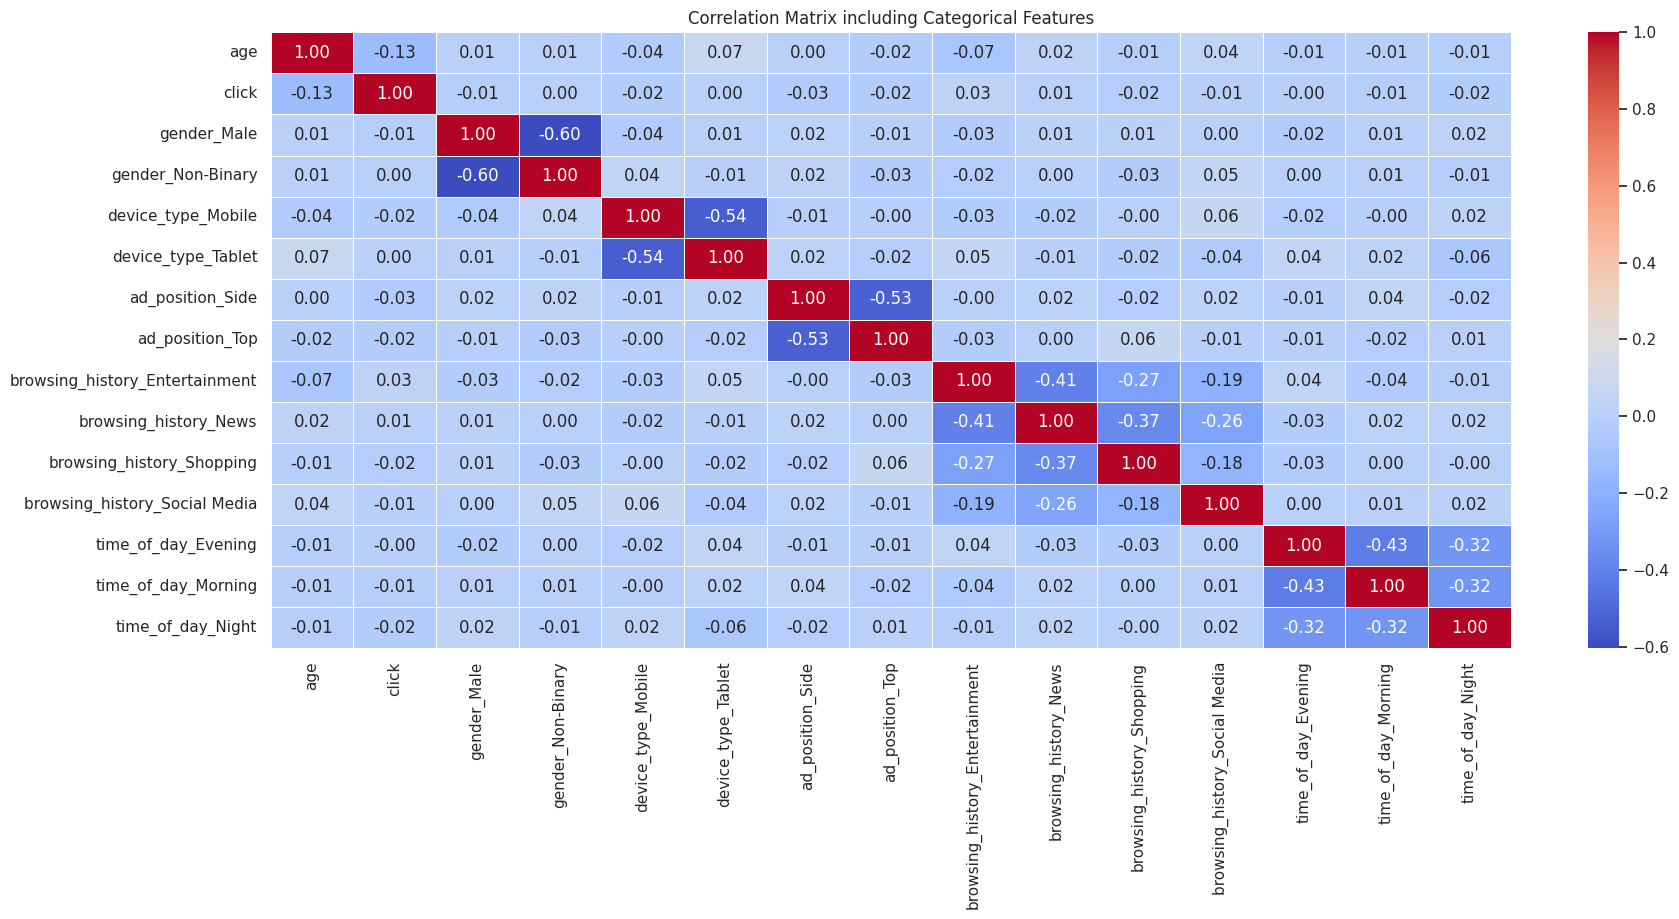

In [91]:
data_encoded = pd.get_dummies(data, drop_first=True)
corr_matrix = data_encoded.corr()

# Heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()


In [92]:
corr_matrix['click']

age                              -0.131203
click                             1.000000
gender_Male                      -0.012012
gender_Non-Binary                 0.000101
device_type_Mobile               -0.023212
device_type_Tablet                0.001430
ad_position_Side                 -0.034565
ad_position_Top                  -0.024412
browsing_history_Entertainment    0.026494
browsing_history_News             0.007483
browsing_history_Shopping        -0.018793
browsing_history_Social Media    -0.008279
time_of_day_Evening              -0.004520
time_of_day_Morning              -0.009860
time_of_day_Night                -0.024430
Name: click, dtype: float64

# Outlier

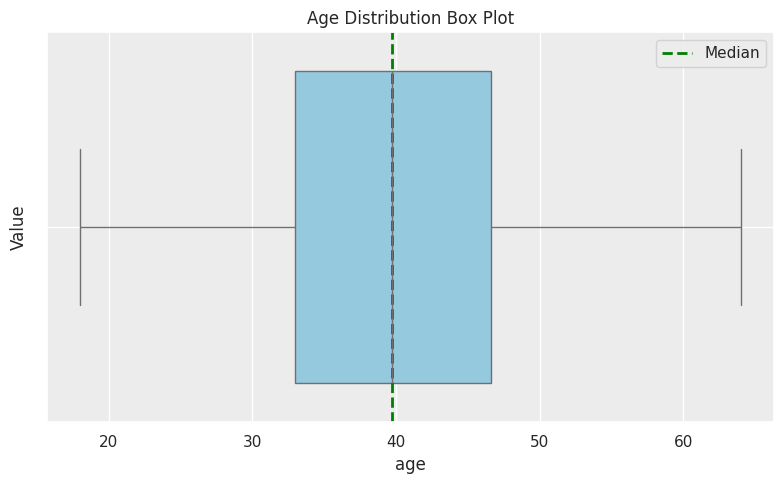

In [93]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="age", color='skyblue', flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
plt.title('Age Distribution Box Plot')
plt.xlabel('age')
plt.ylabel('Value')
median_age = data['age'].median()
plt.axvline(median_age, color='green', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [94]:
min_age = data['age'].min()
max_age = data['age'].max()

print(f"Minimum age value: {min_age}")
print(f"Maximum age value: {max_age}")

Minimum age value: 18.0
Maximum age value: 64.0


**No Outliers**

# Visualizations

## Click

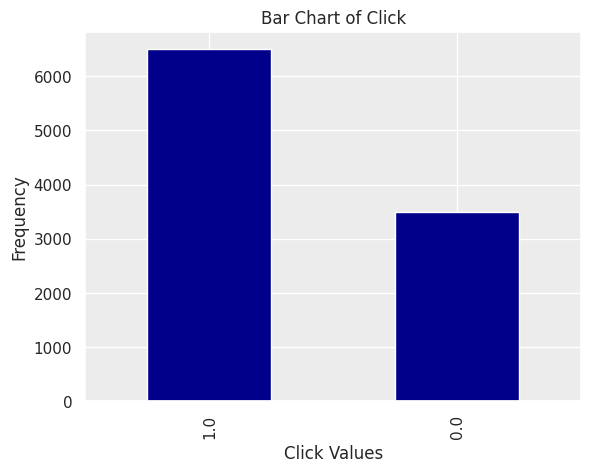

In [95]:
data['click'].value_counts().plot(kind='bar', color='darkblue')
plt.xlabel('Click Values')
plt.ylabel('Frequency')
plt.title('Bar Chart of Click')
plt.show()


In [96]:
distribution_click = data['click'].value_counts(normalize=True) * 100

print(distribution_click)

click
1.0    65.0
0.0    35.0
Name: proportion, dtype: float64


> **Distribution is Imbalanced. Smote or other methods can be considered to balance this.**

## Age

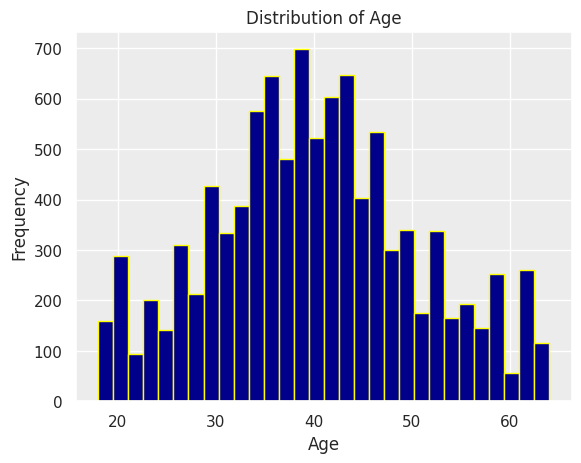

In [97]:
plt.hist(data['age'], bins=30, color='darkblue', edgecolor='yellow')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## Gender

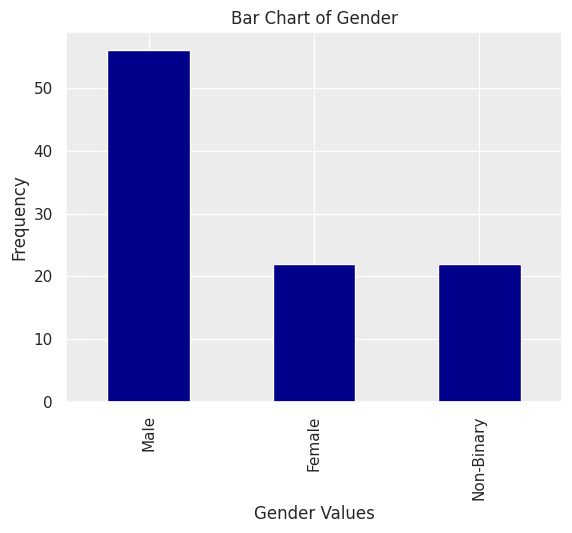

In [98]:
click_counts = data[data['click'] == 1]['gender'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Gender Values')
plt.ylabel('Frequency')
plt.title('Bar Chart of Gender')
plt.show()

> **–ë–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ –≤ –≤—ã–±–æ—Ä–∫–µ —Å–æ—Å—Ç–∞–≤–ª—è—é—Ç –º—É–∂—á–∏–Ω—ã, –ø—Ä–∏–º–µ—Ä–Ω–æ –æ–¥–∏–Ω–∞–∫–æ–≤—ã–µ –¥–æ–ª–∏ –∏–º–µ—é—Ç –∂–µ–Ω—â–∏–Ω—ã –∏ –Ω–µ–±–∏–Ω–∞—Ä–Ω—ã–µ –ø–µ—Ä—Å–æ–Ω—ã**

## Device Type

In [99]:
data['device_type'].value_counts()

device_type
Mobile     4292
Desktop    2945
Tablet     2763
Name: count, dtype: int64

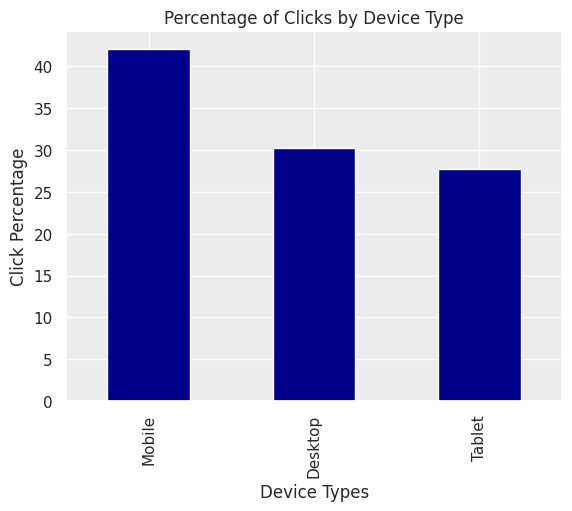

In [100]:
click_counts = data[data['click'] == 1]['device_type'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Device Types')
plt.ylabel('Click Percentage')
plt.title('Percentage of Clicks by Device Type')
plt.show()

> **–ë–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ —Å–æ—Å—Ç–∞–≤–ª—è—é—Ç –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ –º–æ–±–∏–ª—å–Ω—ã—Ö —É—Å—Ç—Ä–æ–π—Å—Ç–≤, –æ—Å—Ç–∞–ª—å–Ω–æ–µ –¥–µ–ª—è—Ç –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ –∫–æ–º–ø—å—é—Ç–µ—Ä–æ–≤ –∏ –ø–ª–∞–Ω—à–µ—Ç–æ–≤**

## Ad Position

In [101]:
data['ad_position'].value_counts()

ad_position
Side      4250
Bottom    3007
Top       2743
Name: count, dtype: int64

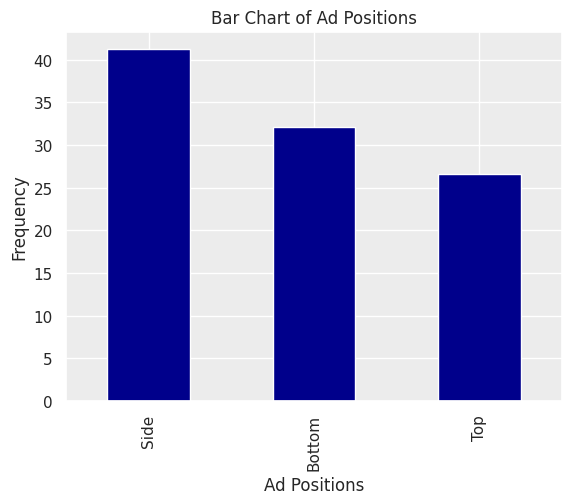

In [102]:
click_counts = data[data['click'] == 1]['ad_position'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Ad Positions')
plt.ylabel('Frequency')
plt.title('Bar Chart of Ad Positions')
plt.show()

## Browsing History

In [103]:
data['browsing_history'].value_counts()

browsing_history
News             3523
Entertainment    2321
Shopping         1992
Social Media     1099
Education        1065
Name: count, dtype: int64

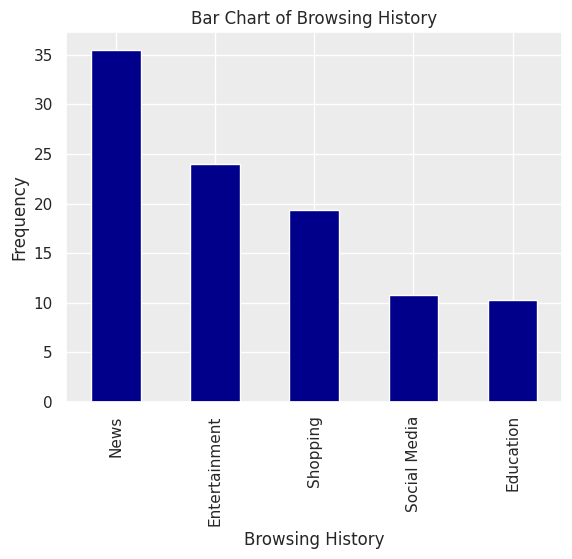

In [104]:
click_counts = data[data['click'] == 1]['browsing_history'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Browsing History')
plt.ylabel('Frequency')
plt.title('Bar Chart of Browsing History')
plt.show()

## Time of Day

In [105]:
data['time_of_day'].value_counts()

time_of_day
Morning      3024
Evening      2969
Afternoon    2070
Night        1937
Name: count, dtype: int64

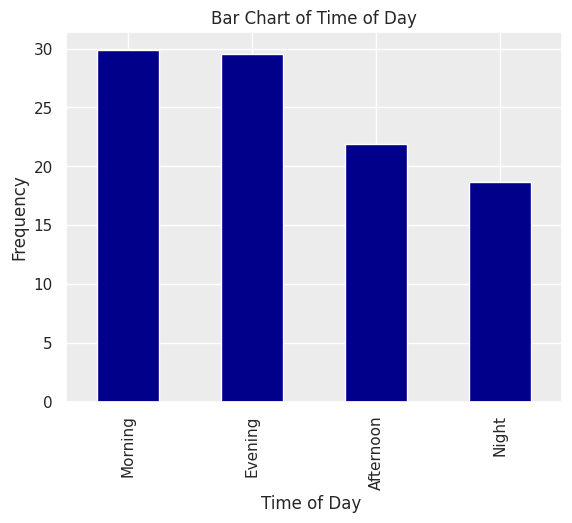

In [106]:
click_counts = data[data['click'] == 1]['time_of_day'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Time of Day ')
plt.ylabel('Frequency')
plt.title('Bar Chart of Time of Day')

plt.show()

## Device Type - Ad Position

## Device Type - Age

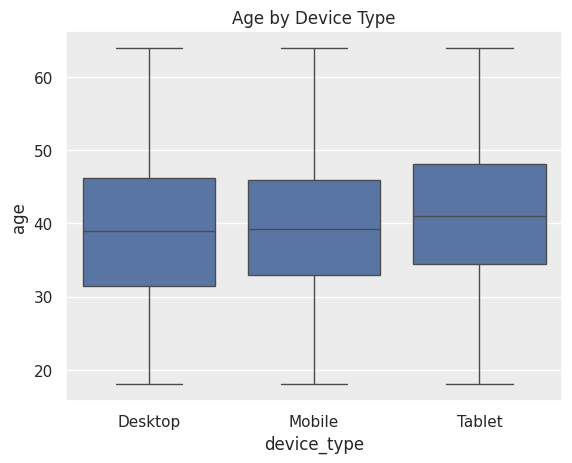

In [107]:
sns.boxplot(x='device_type', y='age', data=data)
plt.title('Age by Device Type')
plt.show()

## Time of Day - Age

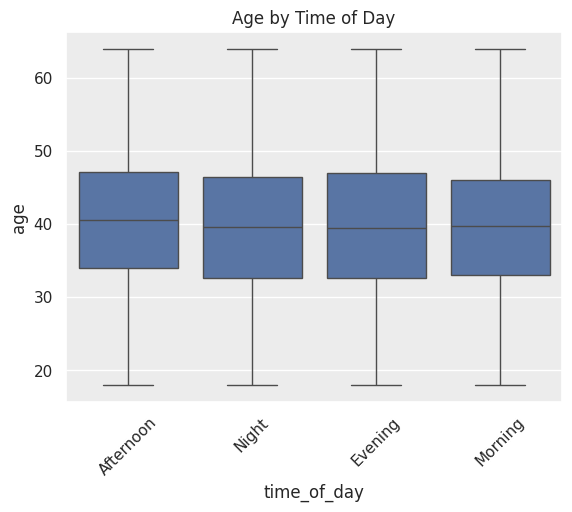

In [108]:
sns.boxplot(x='time_of_day', y='age', data=data)
plt.title('Age by Time of Day')
plt.xticks(rotation=45)
plt.show()

# Encode

In [109]:
for col in cat_cols:
  print('We Have {} Unique values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
  print('__'*30)

We Have 3 Unique values. Values in the gender Column: ['Male' 'Non-Binary' 'Female']
____________________________________________________________
We Have 3 Unique values. Values in the device_type Column: ['Desktop' 'Mobile' 'Tablet']
____________________________________________________________
We Have 3 Unique values. Values in the ad_position Column: ['Top' 'Side' 'Bottom']
____________________________________________________________
We Have 5 Unique values. Values in the browsing_history Column: ['Shopping' 'News' 'Education' 'Entertainment' 'Social Media']
____________________________________________________________
We Have 4 Unique values. Values in the time_of_day Column: ['Afternoon' 'Night' 'Evening' 'Morning']
____________________________________________________________


In [110]:
data = pd.get_dummies(data, columns=cat_cols.columns, drop_first=True).astype(int)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   age                             10000 non-null  int64
 1   click                           10000 non-null  int64
 2   gender_Male                     10000 non-null  int64
 3   gender_Non-Binary               10000 non-null  int64
 4   device_type_Mobile              10000 non-null  int64
 5   device_type_Tablet              10000 non-null  int64
 6   ad_position_Side                10000 non-null  int64
 7   ad_position_Top                 10000 non-null  int64
 8   browsing_history_Entertainment  10000 non-null  int64
 9   browsing_history_News           10000 non-null  int64
 10  browsing_history_Shopping       10000 non-null  int64
 11  browsing_history_Social Media   10000 non-null  int64
 12  time_of_day_Evening             10000 non-null  int64
 13  ti

# Models

In [112]:
KNN = data.copy()
Logistic = data.copy()

## KNN

In [113]:
X = KNN.drop('click', axis=1)
y = KNN['click']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

In [116]:
# create numpy array for future K value
neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [117]:
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

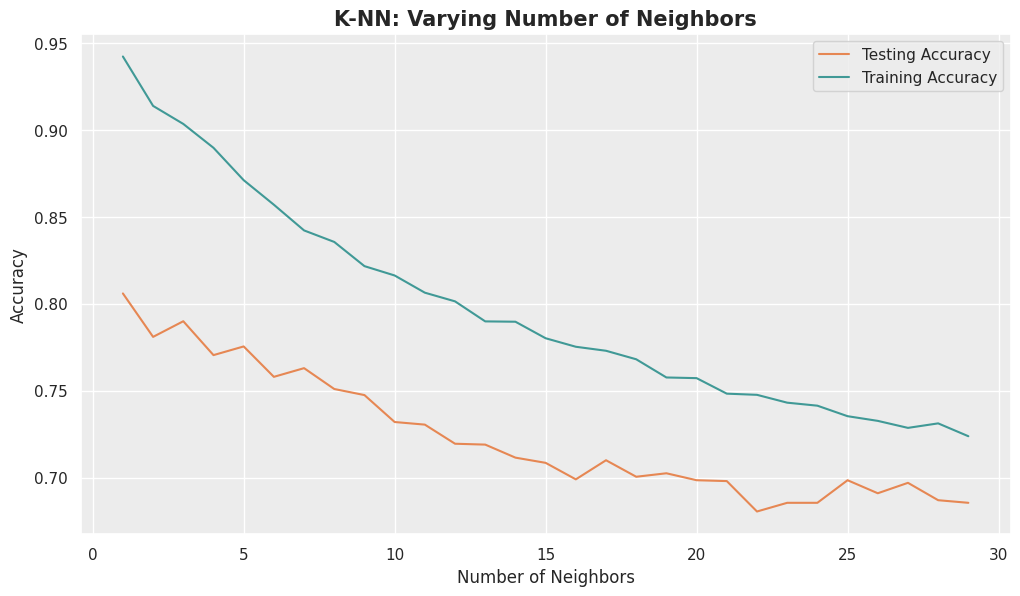

In [118]:
# Generate plot
sns.set(rc={'axes.facecolor':'#ECECEC'}) #background color of all plots
plt.figure(figsize=(12,6.5))
plt.title(label='K-NN: Varying Number of Neighbors', fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy', color='#E68753')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy', color = '#409996')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [119]:
classifier_knn = KNeighborsClassifier(n_neighbors = 3, weights='distance', algorithm = 'auto')

classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [120]:
y_pred = classifier_knn.predict(X_test)

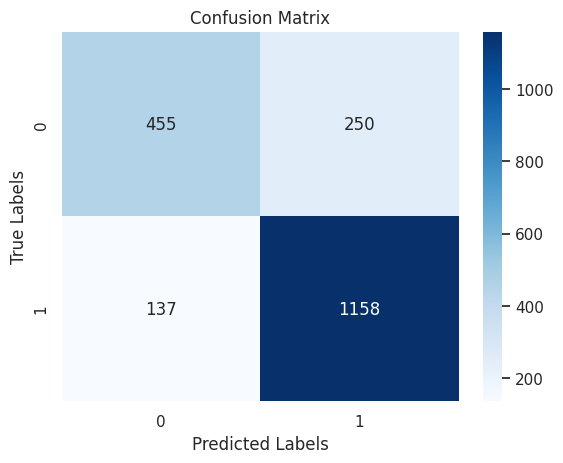

In [121]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [122]:
accuracy_knn = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_knn)

precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)

print("Precision:", precision_knn)
print("Recall:", recall_knn)

f1_knn = f1_score(y_test, y_pred)
print("F1 Score:", f1_knn)

Accuracy: 0.8065
Precision: 0.8224431818181818
Recall: 0.8942084942084942
F1 Score: 0.8568257491675916


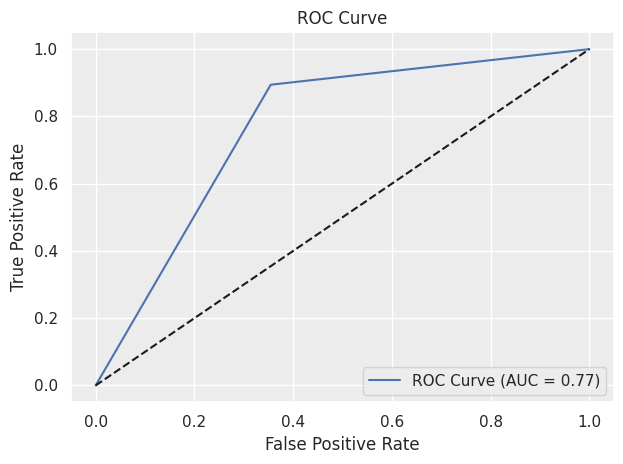

In [123]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Logistic

In [124]:
X = Logistic.drop("click", axis=1)
y = Logistic["click"]

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [126]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

In [127]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [128]:
y_pred = logistic_reg.predict(X_test)

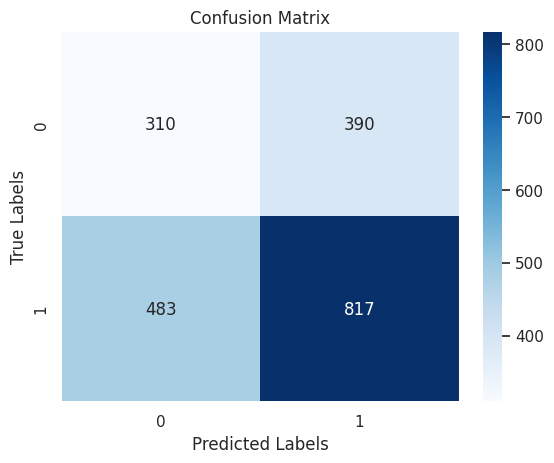

In [129]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [130]:
accuracy_log = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_log)

precision_log = precision_score(y_test, y_pred)
recall_log = recall_score(y_test, y_pred)

print("Precision:", precision_log)
print("Recall:", recall_log)

f1_log = f1_score(y_test, y_pred)
print("F1 Score:", f1_log)

Accuracy: 0.5635
Precision: 0.6768848384424192
Recall: 0.6284615384615385
F1 Score: 0.6517750299162346


In [131]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report

# –°–æ–∑–¥–∞–µ–º –æ–±—ä–µ–∫—Ç –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –ø–æ–ª–∏–Ω–æ–º–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
poly = PolynomialFeatures(degree=2, include_bias=False)

# –ì–µ–Ω–µ—Ä–∏—Ä—É–µ–º –ø–æ–ª–∏–Ω–æ–º–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è –æ–±—É—á–∞—é—â–µ–π –≤—ã–±–æ—Ä–∫–∏
X_train_poly = poly.fit_transform(X_train)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ—Å—Ç–æ–≤—É—é –≤—ã–±–æ—Ä–∫—É
X_test_poly = poly.transform(X_test)

# –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª—å –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

# –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ –ø–æ–ª–∏–Ω–æ–º–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
log_reg.fit(X_train_poly, y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ–º –æ—Ç–≤–µ—Ç—ã –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏
y_pred = log_reg.predict(X_test_poly)

# –û—Ü–µ–Ω–∏–≤–∞–µ–º –∫–∞—á–µ—Å—Ç–≤–æ –º–æ–¥–µ–ª–∏
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.50      0.45       700
           1       0.70      0.61      0.65      1300

    accuracy                           0.57      2000
   macro avg       0.55      0.56      0.55      2000
weighted avg       0.60      0.57      0.58      2000



In [132]:
accuracy_log = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_log)

precision_log = precision_score(y_test, y_pred)
recall_log = recall_score(y_test, y_pred)

print("Precision:", precision_log)
print("Recall:", recall_log)

f1_log = f1_score(y_test, y_pred)
print("F1 Score:", f1_log)

Accuracy: 0.5735
Precision: 0.6951965065502184
Recall: 0.6123076923076923
F1 Score: 0.6511247443762781


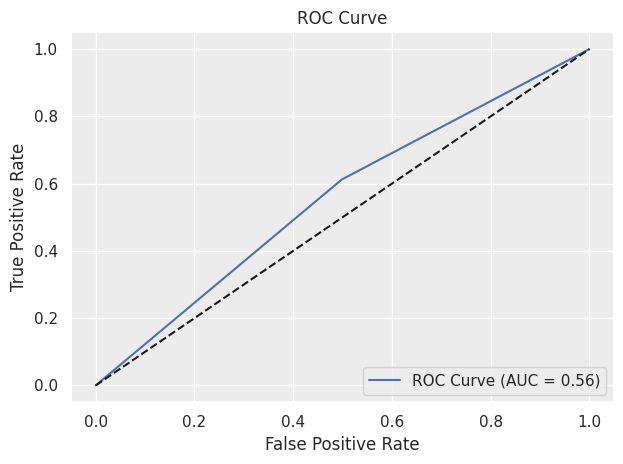

In [133]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

–¢–µ—Å—Ç –†–∞–º—Å–µ—è (RESET-—Ç–µ—Å—Ç) (–ø—Ä–æ–≤–µ—Ä–∫–∞ –ø—Ä–∞–≤–∏–ª—å–Ω–æ—Å—Ç–∏ —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞—Ü–∏–∏ —Ä–µ–≥—Ä–µ—Å—Å–∏–∏)

In [134]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# –°—Ç—Ä–æ–∏–º –ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫—É—é —Ä–µ–≥—Ä–µ—Å—Å–∏—é
model = sm.Logit(y, X).fit()

# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ç–µ—Å—Ç –†–∞–º—Å–µ—è (–ø—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –Ω–µ–ª–∏–Ω–µ–π–Ω—ã—Ö —Å–≤—è–∑–µ–π)
reset_test = linear_reset(model, power=2, use_f=True)

print('–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ F-—Ç–µ—Å—Ç–∞:', reset_test.fvalue)
print('P-–∑–Ω–∞—á–µ–Ω–∏–µ:', reset_test.pvalue)

# –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è:
if reset_test.pvalue < 0.05:
    print('–í—ã–≤–æ–¥: –º–æ–¥–µ–ª—å –∏–º–µ–µ—Ç –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –Ω–µ–ª–∏–Ω–µ–π–Ω–æ—Å—Ç–∏, —Å—Ç–æ–∏—Ç –ø–µ—Ä–µ—Å–º–æ—Ç—Ä–µ—Ç—å —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞—Ü–∏—é.')
else:
    print('–í—ã–≤–æ–¥: —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–∞.')


Optimization terminated successfully.
         Current function value: 0.648524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.648471
         Iterations 5
–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ F-—Ç–µ—Å—Ç–∞: 1.0729357180094727
P-–∑–Ω–∞—á–µ–Ω–∏–µ: 0.30030836162183383
–í—ã–≤–æ–¥: —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–∞.


In [135]:
coefficients = log_reg.coef_[0]  # –í log_reg —É–∂–µ –æ–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å

# –ü–æ–ª—É—á–∞–µ–º –∏–º–µ–Ω–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
feature_names = poly.get_feature_names_out(X.columns)

# –°–æ–∑–¥–∞–µ–º DataFrame –¥–ª—è –Ω–∞–≥–ª—è–¥–Ω–æ—Å—Ç–∏
feature_importance = pd.DataFrame({
    '–ü—Ä–∏–∑–Ω–∞–∫': feature_names,
    '–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç': coefficients
})

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∞–±—Å–æ–ª—é—Ç–Ω–æ–π –≤–µ–ª–∏—á–∏–Ω–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞
feature_importance['|–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç|'] = feature_importance['–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç'].abs()
feature_importance = feature_importance.sort_values(by='|–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç|', ascending=False)

# –í—ã–≤–æ–¥–∏–º –≤–∞–∂–Ω–æ—Å—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
print(feature_importance[['–ü—Ä–∏–∑–Ω–∞–∫', '–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç']])

                                               –ü—Ä–∏–∑–Ω–∞–∫  –ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç
60    device_type_Mobile browsing_history_Social Media     0.555069
32                        gender_Male ad_position_Side     0.503205
89                 ad_position_Top time_of_day_Morning     0.497617
45                   gender_Non-Binary ad_position_Top    -0.482500
69        device_type_Tablet browsing_history_Shopping    -0.477980
..                                                 ...          ...
94   browsing_history_Entertainment browsing_histor...     0.000000
105  browsing_history_Shopping browsing_history_Soc...     0.000000
114            time_of_day_Evening time_of_day_Morning     0.000000
115              time_of_day_Evening time_of_day_Night     0.000000
117              time_of_day_Morning time_of_day_Night     0.000000

[119 rows x 2 columns]


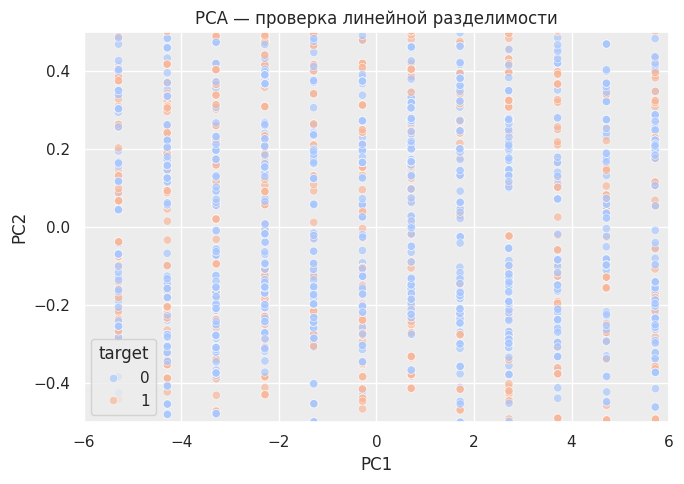

In [136]:
# üß© –®—É–º–Ω–æ—Å—Ç—å ‚Äî PCA Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['target'] = y_train.values

plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', alpha=0.7, palette='coolwarm')
plt.title("PCA ‚Äî –ø—Ä–æ–≤–µ—Ä–∫–∞ –ª–∏–Ω–µ–π–Ω–æ–π —Ä–∞–∑–¥–µ–ª–∏–º–æ—Å—Ç–∏")
plt.xlim([-6, 6])
plt.ylim([-0.5, 0.5])
plt.tight_layout()
plt.show()